# CellProfiler Example Notebook

The cellprofiler example notebook came from the [CellProfiler notebooks repo](https://github.com/CellProfiler/notebooks/blob/master/cellprofiler_demo.ipynb) with thanks. The only changes that were made were fix some import errors for CellProfiler v4.

Data comes from the [CellProfiler notebook repo](https://github.com/CellProfiler/notebooks/tree/master/data).

In [1]:
import os

import cellprofiler
import cellprofiler_core
import cellprofiler_core.pipeline
from cellprofiler_core.preferences import set_headless

import cellprofiler_core.image
import cellprofiler_core.measurement

import cellprofiler.modules.maskimage
import cellprofiler_core.pipeline
import cellprofiler_core.workspace

import numpy as np
import pandas as pd
import skimage.io

In [2]:
def run_pipeline(pipeline_filename, image_dict):
    set_headless()
    
    # Create and load the pipeline
    pipeline = cellprofiler_core.pipeline.Pipeline()
    pipeline.load(pipeline_filename)
    
    # Create the image set, and add the image data
    image_set_list = cellprofiler_core.image.ImageSetList()
    image_set = image_set_list.get_image_set(0)
    for image_name, input_pixels in image_dict.items():
        image_set.add(image_name, cellprofiler_core.image.Image(input_pixels))
        
    # Persist the object set here (for now, see workspace TODO)
    object_set = cellprofiler_core.object.ObjectSet()

    # We can only run one group -- set the group index to 1.
    measurements = cellprofiler_core.measurement.Measurements()
    measurements.group_index = 1

    # Run the modules!
    for module in pipeline.modules():
        # Yes, we really do have to create a new workspace for each module
        # because the module attribute is required. Go team.
        workspace = cellprofiler_core.workspace.Workspace(
            image_set=image_set,
            image_set_list=image_set_list,
            measurements=measurements, 
            module=module,
            object_set=object_set, 
            pipeline=pipeline
        )
        
        module.prepare_run(workspace)
        module.run(workspace)
        module.post_run(workspace)
    
    # The workspace object has access to the measurements
    # and the image set/image set list which can be used
    # to use/view/store/whatever output data.
    return workspace

In [3]:
def objects2df(measurements, objects_name):
    features = measurements.get_feature_names(objects_name)
    
    n_features = len(features)
    n_objects = int(measurements.get_measurement("Image", "Count_{}".format(objects_name)))
    
    data = np.empty((n_objects, n_features))
    
    for feature_idx, feature in enumerate(features):
        data[:, feature_idx] = measurements.get_measurement(objects_name, feature)
    
    return pd.DataFrame(
        data=data,
        index=np.arange(1, n_objects + 1),
        columns=features
    )

In [4]:
os.getcwd()

'/home/jovyan/biohub-notebooks/docs/_source/cellprofiler'

In [5]:
# This should match what NamesAndTypes would produce.
data_dir = os.path.join(os.getcwd(), "data")


images = {
    "OrigBlue": skimage.io.imread(os.path.join(data_dir, "images/01_POS002_D.TIF")),
    "OrigGreen": skimage.io.imread(os.path.join(data_dir, "images/01_POS002_F.TIF")),
    "OrigRed": skimage.io.imread(os.path.join(data_dir, "images/01_POS002_R.TIF"))
}

pipeline_filename = os.path.join(data_dir , "ExampleFly.cppipe")

In [6]:
workspace = run_pipeline(pipeline_filename, images)

In [7]:
# Get the "Nuclei" object measurements, as a pandas DataFrame
df = objects2df(workspace.measurements, "Nuclei")
df.head()

,AreaShape_Area,AreaShape_BoundingBoxArea,AreaShape_BoundingBoxMaximum_X,AreaShape_BoundingBoxMaximum_Y,AreaShape_BoundingBoxMinimum_X,AreaShape_BoundingBoxMinimum_Y,AreaShape_Center_X,AreaShape_Center_Y,AreaShape_Compactness,AreaShape_Eccentricity,...,Texture_SumEntropy_CropBlue_3_02_256,Texture_SumEntropy_CropBlue_3_03_256,Texture_SumVariance_CropBlue_3_00_256,Texture_SumVariance_CropBlue_3_01_256,Texture_SumVariance_CropBlue_3_02_256,Texture_SumVariance_CropBlue_3_03_256,Texture_Variance_CropBlue_3_00_256,Texture_Variance_CropBlue_3_01_256,Texture_Variance_CropBlue_3_02_256,Texture_Variance_CropBlue_3_03_256
1,372.0,459.0,149.0,37.0,122.0,20.0,135.282258,28.174731,1.154250,0.766482,...,6.386346,6.350746,751.956406,501.186523,633.977067,640.784132,219.438478,222.919307,219.703030,219.534215
2,333.0,460.0,98.0,60.0,78.0,37.0,87.207207,47.597598,1.160894,0.705159,...,6.507063,6.502537,831.599848,483.017698,847.022904,878.240345,303.378182,312.699600,305.388510,300.244349
3,199.0,256.0,33.0,55.0,17.0,39.0,24.547739,46.457286,1.024964,0.653637,...,5.596830,5.642043,244.783913,156.381954,269.975878,251.388361,107.455912,110.388521,101.904566,100.657374
4,329.0,441.0,24.0,77.0,3.0,56.0,13.504559,65.595745,1.089441,0.327322,...,6.136639,6.072976,590.040062,449.609248,597.510359,483.699149,222.137356,236.203965,230.477777,224.442496
5,211.0,300.0,49.0,84.0,34.0,64.0,40.796209,72.919431,1.135477,0.704184,...,5.737125,5.702339,297.112222,245.400604,333.682537,281.726804,121.854853,128.724225,114.486899,124.693854


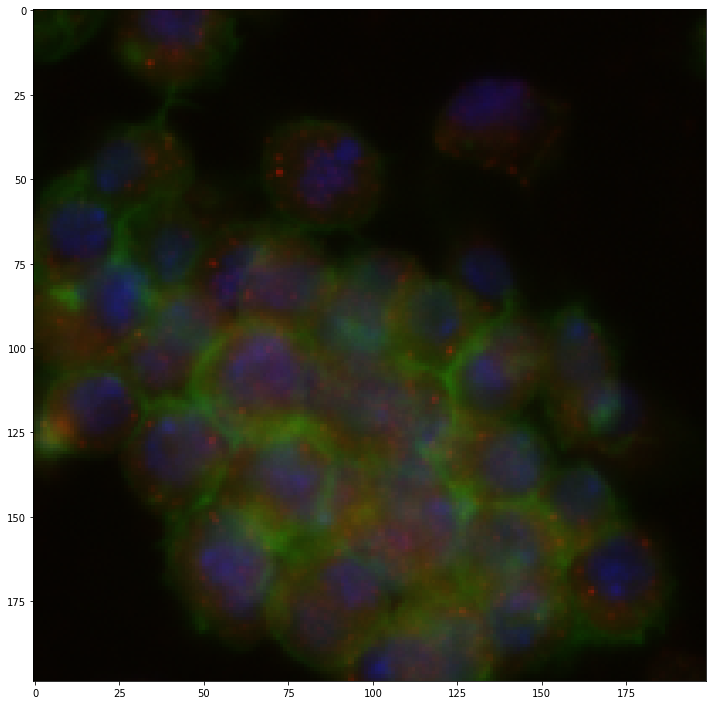

In [8]:
# Display the "RGBImage" image, created by GrayToColor

from pylab import rcParams
rcParams['figure.figsize'] = 10, 15

rgb_image = workspace.image_set.get_image("RGBImage")
skimage.io.imshow(rgb_image.pixel_data)

## Get Help

```python
help(workspace.measurements)
```

## Additional Considerations

### Saving Data Frames

Generally,  you run an experiment, and then you want to save your data. CellProfiler creates CSVs, which play nicely with the rest of the PyData And RTidyVerse ecosystem.

#### Save as a CSV

You can always just save your experiment outputs as CSVs.

```python
df.to_csv('experiment-plate.csv')
```

#### Save as a Parquet

My favorite way to save data, particularly if it is scientific data, is as a [Parquet File](https://parquet.apache.org/). A parquet file is a dataframe in machine readable format, which will save you quite a bit on both performance.

```python
df.to_parquet('experiment-plate.parquet')
```

#### Save to S3

You can save to S3 instead of local storage using [S3FS](https://s3fs.readthedocs.io/en/latest/#integration):

```python
df.to_parquet("s3://bucket/path/experiment-plate.parquet", storage_options={"anon": True})
```
